# Setting

In [1]:
pip install seaborn statsmodels pmdarima xgboost lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Data Preprocessing

In [41]:
import pandas as pd

# CSV 파일 로드
file_path = "data/ESG_CO2_2021.csv"
df = pd.read_csv(file_path)

# 데이터 확인
print(df.head())   # 앞부분 5개 행 출력
print(df.info())   # 데이터 타입 및 결측값 확인
print(df.describe())  # 기본 통계 정보 확인

   year          Net
0  1990  254159.2211
1  1991  281385.5253
2  1992  310216.9541
3  1993  346994.1520
4  1994  369637.1600
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    32 non-null     int64  
 1   Net     32 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 640.0 bytes
None
              year            Net
count    32.000000      32.000000
mean   2005.500000  511113.240587
std       9.380832  124286.844277
min    1990.000000  254159.221100
25%    1997.750000  428908.157325
50%    2005.500000  507308.536350
75%    2013.250000  638025.741225
max    2021.000000  684683.642100


In [42]:
print(df.isnull().sum())  # 각 컬럼의 NaN 개수 출력

year    0
Net     0
dtype: int64


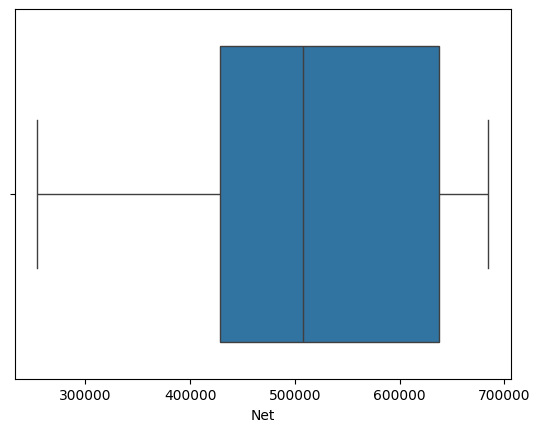

In [43]:
import seaborn as sns

# 이상치 확인 : 이상치 없음
sns.boxplot(x=df["Net"])
plt.show()

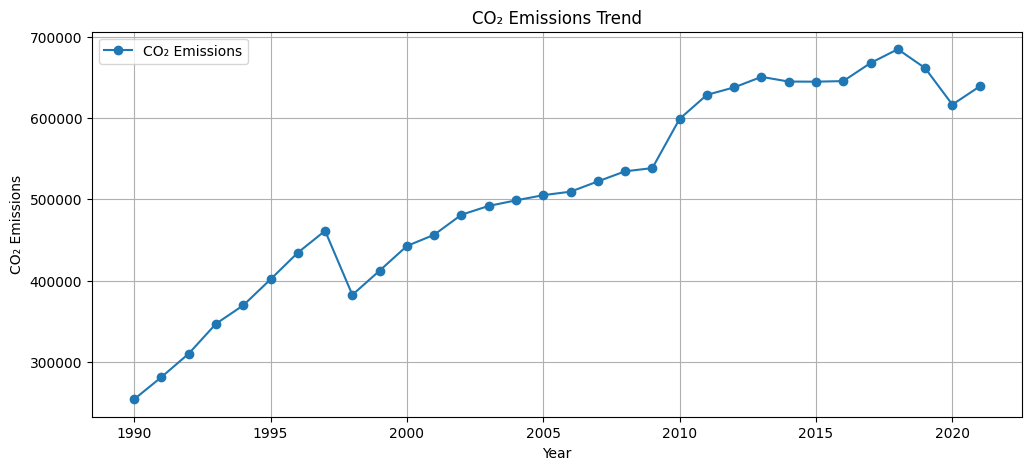

In [44]:
# 연도별 CO₂ 배출량 집계 (합계 또는 평균)
yearly_emission = df.groupby("year")["Net"].sum().reset_index()

# 시계열 데이터 시각화
plt.figure(figsize=(12, 5))
plt.plot(df["year"], df["Net"], marker="o", linestyle="-", label="CO₂ Emissions")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions")
plt.title("CO₂ Emissions Trend")
plt.legend()
plt.grid()
plt.show()

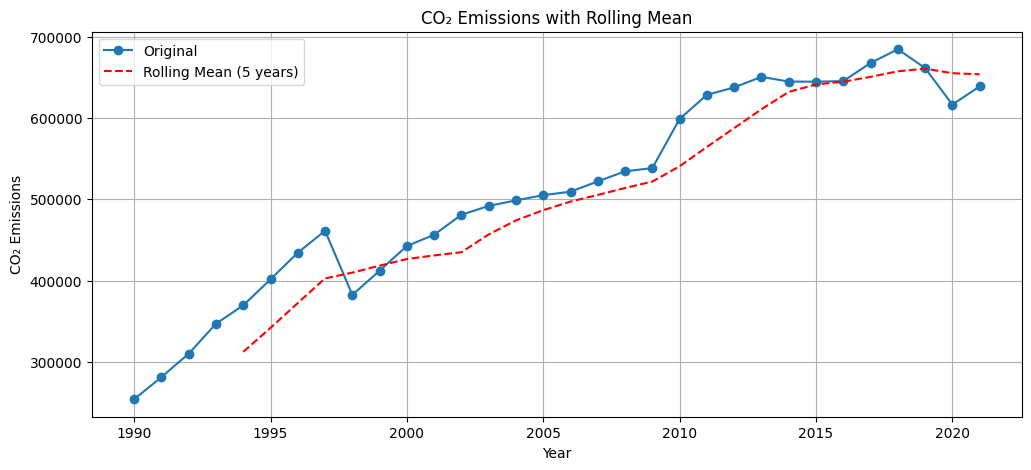

In [45]:
# 이동 평균 적용 (트렌드 확인)
df["rolling_mean"] = df["Net"].rolling(window=5).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["year"], df["Net"], label="Original", linestyle="-", marker="o")
plt.plot(df["year"], df["rolling_mean"], label="Rolling Mean (5 years)", linestyle="--", color="red")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions")
plt.title("CO₂ Emissions with Rolling Mean")
plt.legend()
plt.grid()
plt.show()

# Regression Modeling

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["Net_scaled"] = scaler.fit_transform(df[["Net"]])

In [47]:
# 연도를 숫자로 변환
df["year"] = df["year"].astype(int)

# 독립 변수(X)와 종속 변수(y) 설정
X = df["year"].values.reshape(-1, 1)  # 연도
y = df["Net_scaled"].values  # 정규화된 CO₂ 배출량

In [48]:
from sklearn.metrics import mean_squared_error

def plot_predictions(df, model, X, X_poly=None, poly_degree=None, future_years=None, future_predictions=None, model_name="Model"):

    # 결과 출력 (역정규화 적용)
    forecast_df = pd.DataFrame({
        "year": future_years.flatten(),
        "Net_Predicted": scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()
    })
    print(forecast_df)

    plt.figure(figsize=(12, 5))
    
    # 실제 데이터 플롯
    plt.scatter(df["year"], df["Net_scaled"], label="Actual Data", color="blue")
    
    # 모델이 다항 회귀일 경우
    if X_poly is not None and poly_degree is not None:
        plt.plot(df["year"], model.predict(X_poly), label=f"Polynomial Regression (Degree={poly_degree})", color="green", linestyle="dashed")
    else:
        plt.plot(df["year"], model.predict(X), label=f"{model_name}", color="green", linestyle="dashed")

    # 미래 예측 데이터 플롯
    if future_years is not None and future_predictions is not None:
        plt.scatter(future_years, future_predictions, label="Predicted", color="red")

    # MSE 계산
    if 'X_test' in globals() and 'y_test' in globals():
        y_pred_test = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred_test)
        print(f"🔹 {model_name} Test MSE: {mse:.4f}")

    # 그래프 설정
    plt.xlabel("Year")
    plt.ylabel("Net CO₂ Emissions")
    plt.title(f"CO₂ Emissions Forecast using {model_name}")
    plt.legend()
    plt.grid()
    plt.show()

## Linear Regression

### Random Split

   year  Net_Predicted
0  2022  735355.650494
1  2023  748597.151041
2  2024  761838.651587
3  2025  775080.152134
4  2026  788321.652680
🔹 Model Test MSE: 0.0090


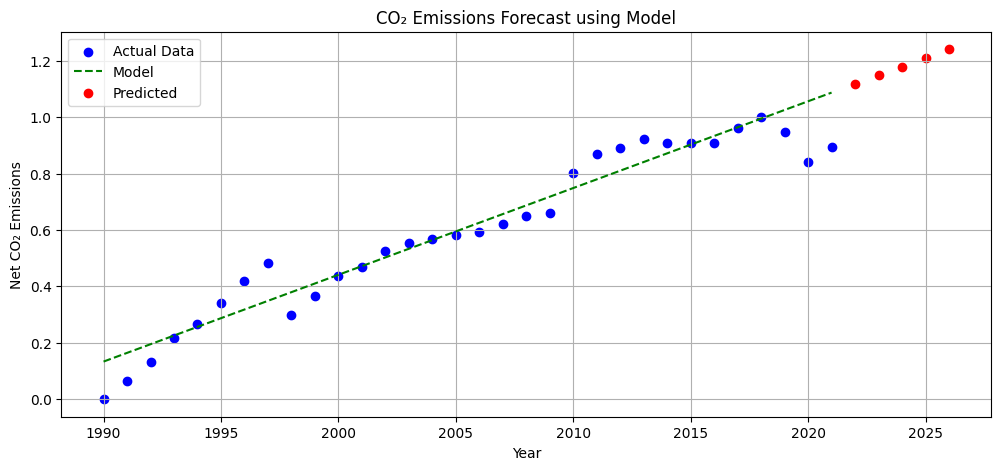

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

future_years = np.arange(df["year"].max() + 1, df["year"].max() + 6).reshape(-1, 1)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 미래 예측
future_predictions = model.predict(future_years)

# 시각화
plot_predictions(df, model, X, future_years=future_years, future_predictions=future_predictions)

### 과거 80 / 이후 20 - Train Test Split

   year  Net_Predicted
0  2022  767098.138668
1  2023  781860.948374
2  2024  796623.758080
3  2025  811386.567785
4  2026  826149.377491
🔹 Model Test MSE: 0.0261


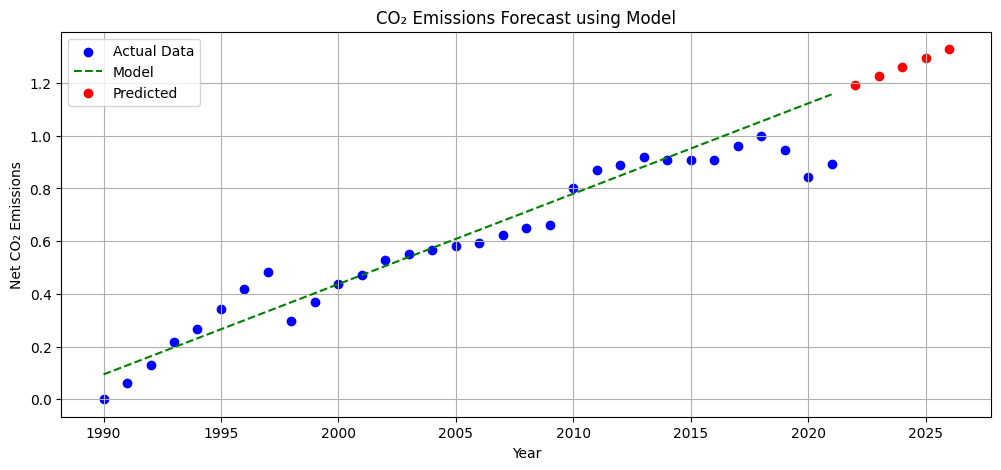

In [50]:
# 시계열 데이터: 과거 80% → 학습 / 이후 20% → 테스트
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

future_years = np.arange(df["year"].max() + 1, df["year"].max() + 6).reshape(-1, 1)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 미래 예측
future_predictions = model.predict(future_years)

# 시각화 
plot_predictions(df, model, X, future_years=future_years, future_predictions=future_predictions)

### TimeSeriesSplit

Fold MSE: 0.0566
Fold MSE: 0.0051
Fold MSE: 0.0037
Fold MSE: 0.0021
Fold MSE: 0.0290
평균 MSE: 0.0193
   year  Net_Predicted
0  2022  757543.066683
1  2023  771904.426885
2  2024  786265.787086
3  2025  800627.147288
4  2026  814988.507490
🔹 Model Test MSE: 0.0290


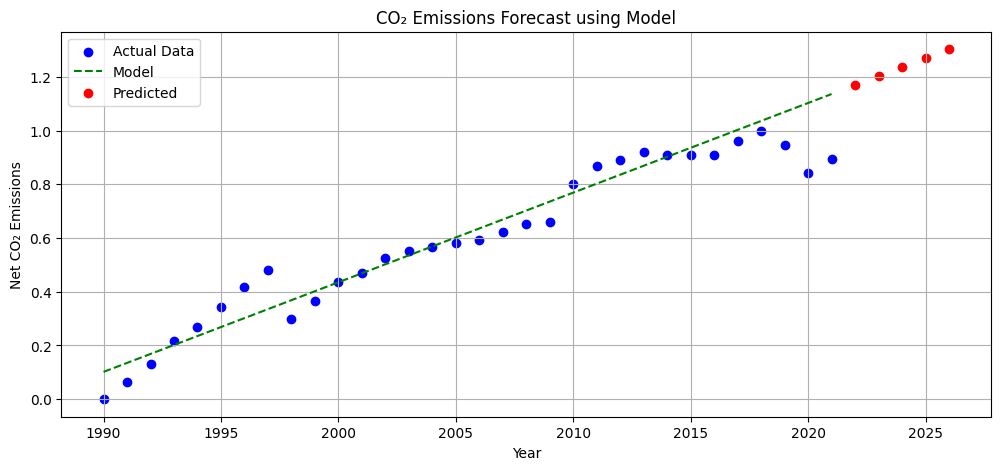

In [51]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    
# TimeSeriesSplit 설정 (5개 분할)
tscv = TimeSeriesSplit(n_splits=5)

# MSE 저장 리스트
mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 선형 회귀 모델 학습
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 테스트 데이터 MSE 계산
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    mse_scores.append(mse)

    print(f"Fold MSE: {mse:.4f}")

# 평균 MSE 출력
print(f"평균 MSE: {np.mean(mse_scores):.4f}")

# 미래 예측
future_predictions = model.predict(future_years)

# 시각화
plot_predictions(df, model, X, future_years=future_years, future_predictions=future_predictions)

## 다항 회귀

### 과거 80 / 이후 20 - Train Test Split

   year  Net_Predicted
0  2022  750498.971282
1  2023  763306.131956
2  2024  776017.895117
3  2025  788634.260764
4  2026  801155.228898
🔹 Model Test MSE: 0.0195


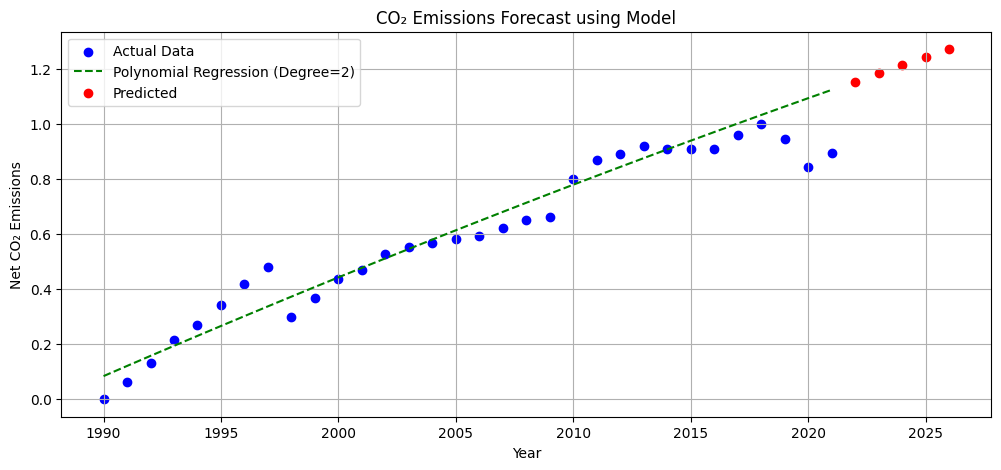

In [52]:
# 다항 회귀 변환 (2차 다항식)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 시계열 데이터 분할: 과거 80% → 학습 / 이후 20% → 테스트
train_size = int(len(df) * 0.8)
X_train, X_test = X_poly[:train_size], X_poly[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 미래 예측
future_years_poly = poly.transform(future_years)
future_predictions = model.predict(future_years_poly)

# 시각화
plot_predictions(df, model, X, X_poly=X_poly, poly_degree=2, future_years=future_years, future_predictions=future_predictions)

### TimeSeriesSplit

Fold MSE: 0.0642
Fold MSE: 0.0547
Fold MSE: 0.0303
Fold MSE: 0.0059
Fold MSE: 0.0167
✅ 평균 MSE: 0.0344
   year  Net_Predicted
0  2022  728217.432279
1  2023  738770.691231
2  2024  749128.662941
3  2025  759291.347406
4  2026  769258.744629
🔹 Model Test MSE: 0.0167


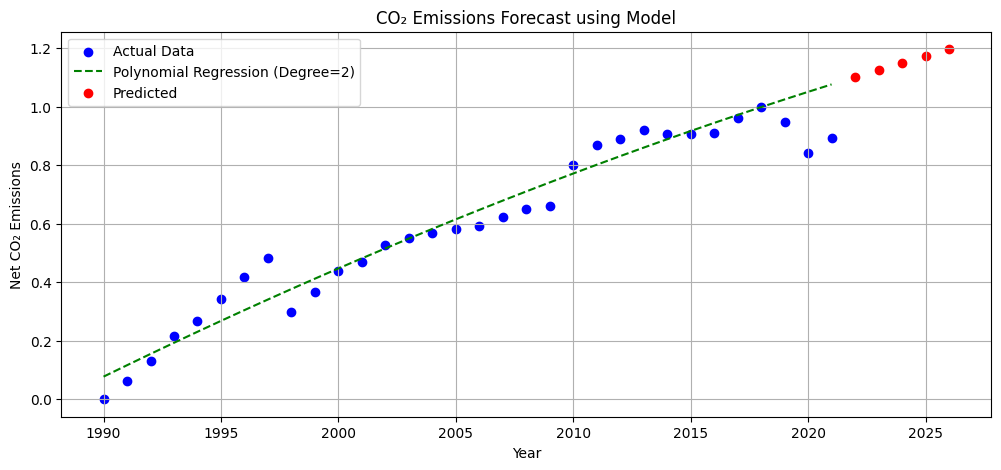

In [53]:
# 다항 회귀 변환 (2차 다항식)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(X_poly):
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 다항 회귀 모델 학습
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 테스트 데이터 예측 및 MSE 계산
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    mse_scores.append(mse)

    print(f"Fold MSE: {mse:.4f}")

# 평균 MSE 출력
print(f"✅ 평균 MSE: {np.mean(mse_scores):.4f}")

# 미래 예측
future_years_poly = poly.transform(future_years)  # 미래 연도 변환
future_predictions = model.predict(future_years_poly)  # 변환된 값으로 예측

# 시각화
plot_predictions(df, model, X, X_poly=X_poly, poly_degree=2, future_years=future_years, future_predictions=future_predictions)

### 과거 80 / 이후 20 - Train Test Split

   year  Net_Predicted
0  2022   1.072015e+06
1  2023   1.146043e+06
2  2024   1.226582e+06
3  2025   1.313947e+06
4  2026   1.408453e+06
🔹 Model Test MSE: 0.2632


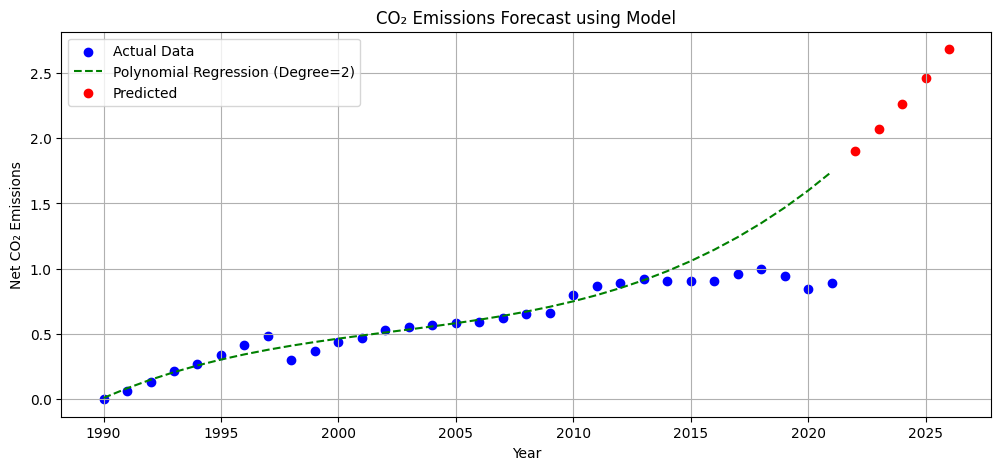

In [54]:
# 다항 회귀 변환 (2차 다항식)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# 시계열 데이터 분할: 과거 80% → 학습 / 이후 20% → 테스트
train_size = int(len(df) * 0.8)
X_train, X_test = X_poly[:train_size], X_poly[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 미래 예측
future_years_poly = poly.transform(future_years)
future_predictions = model.predict(future_years_poly)

# 시각화
plot_predictions(df, model, X, X_poly=X_poly, poly_degree=2, future_years=future_years, future_predictions=future_predictions)

### TimeSeriesSplit

Fold MSE: 0.0688
Fold MSE: 0.0030
Fold MSE: 0.0093
Fold MSE: 0.0898
Fold MSE: 0.0704
✅ 평균 MSE: 0.0483
   year  Net_Predicted
0  2022  840160.233215
1  2023  874840.310545
2  2024  912130.529161
3  2025  952171.162406
4  2026  995102.483422
🔹 Model Test MSE: 0.0704


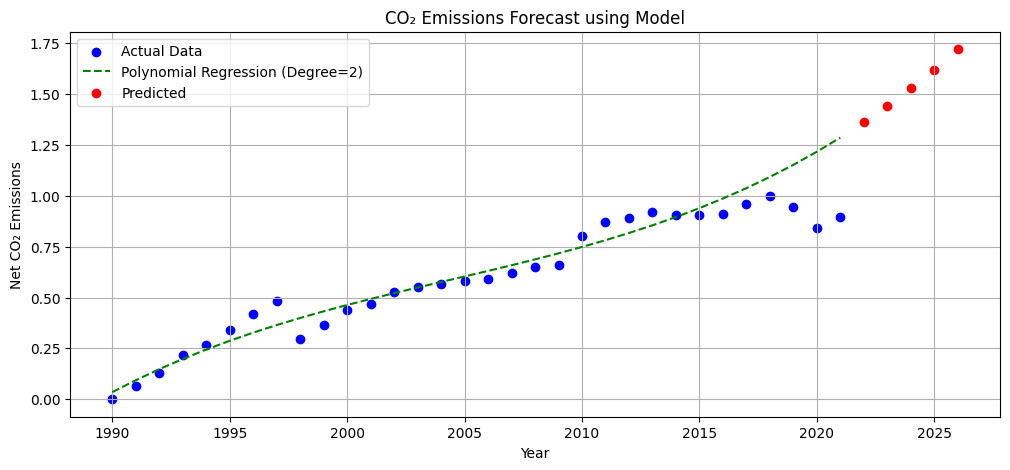

In [55]:
# 다항 회귀 변환 (3차 다항식)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(X_poly):
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 다항 회귀 모델 학습
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 테스트 데이터 예측 및 MSE 계산
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    mse_scores.append(mse)

    print(f"Fold MSE: {mse:.4f}")

# 🔹 평균 MSE 출력
print(f"✅ 평균 MSE: {np.mean(mse_scores):.4f}")

# 🔹 마지막 모델로 미래 예측
future_years_poly = poly.transform(future_years)  # 미래 연도 변환
future_predictions = model.predict(future_years_poly)  # 변환된 값으로 예측

# 🔹 시각화
plot_predictions(df, model, X, X_poly=X_poly, poly_degree=2, future_years=future_years, future_predictions=future_predictions)

# 추가) Random Forest, XGBoost, SVM

Fold MSE: 0.0054
Fold MSE: 0.0126
Fold MSE: 0.0278
Fold MSE: 0.0092
Fold MSE: 0.0034
✅ 평균 MSE: 0.0117
   year  Net_Predicted
0  2022  645405.308953
1  2023  645405.308953
2  2024  645405.308953
3  2025  645405.308953
4  2026  645405.308953
🔹 Random Forest Test MSE: 0.0034


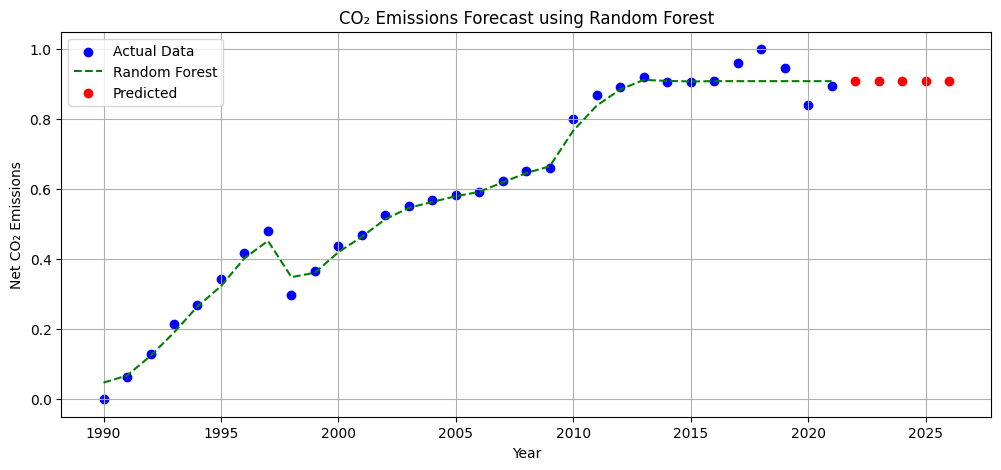

In [56]:
# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 🔹 랜덤 포레스트 회귀 모델 학습
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # 테스트 데이터 예측 및 MSE 계산
    y_pred_test = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    mse_scores.append(mse)

    print(f"Fold MSE: {mse:.4f}")

# 🔹 평균 MSE 출력
print(f"✅ 평균 MSE: {np.mean(mse_scores):.4f}")

# 🔹 마지막 모델로 미래 예측
future_predictions_rf = rf_model.predict(future_years)

# 🔹 시각화
plot_predictions(df, rf_model, X, future_years=future_years, future_predictions=future_predictions_rf, model_name="Random Forest")

Fold MSE: 0.0048
Fold MSE: 0.0098
Fold MSE: 0.0260
Fold MSE: 0.0016
Fold MSE: 0.0035
✅ 평균 MSE: 0.0091
   year  Net_Predicted
0  2022    645061.0625
1  2023    645061.0625
2  2024    645061.0625
3  2025    645061.0625
4  2026    645061.0625
🔹 XGBoost Test MSE: 0.0035


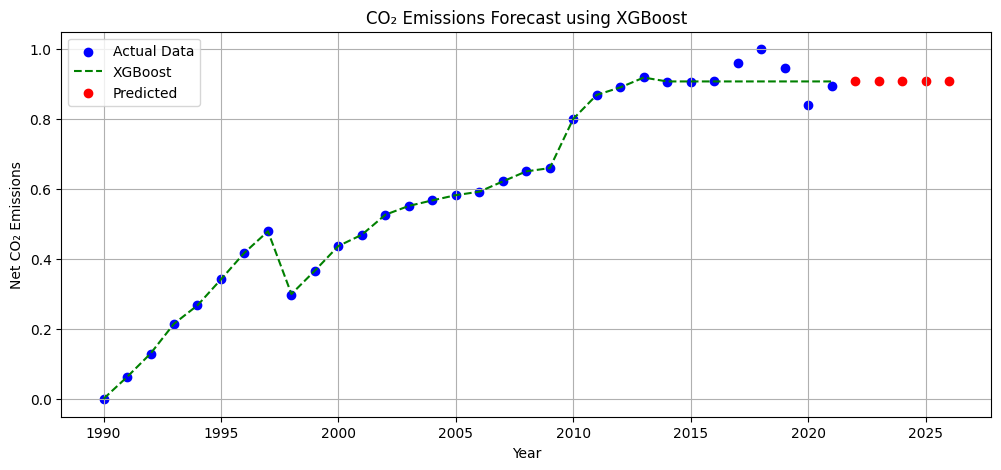

In [57]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 🔹 XGBoost 모델 학습
    xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=15, random_state=42)
    xgb_model.fit(X_train, y_train)

    # 테스트 데이터 예측 및 MSE 계산
    y_pred_test = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    mse_scores.append(mse)

    print(f"Fold MSE: {mse:.4f}")

# 🔹 평균 MSE 출력
print(f"✅ 평균 MSE: {np.mean(mse_scores):.4f}")

# 🔹 마지막 모델로 미래 예측
future_predictions_xgb = xgb_model.predict(future_years)

# 🔹 시각화
plot_predictions(df, xgb_model, X, future_years=future_years, future_predictions=future_predictions_xgb, model_name="XGBoost")

Fold MSE: 0.0295
Fold MSE: 0.0674
Fold MSE: 0.1200
Fold MSE: 0.1137
Fold MSE: 0.0951
✅ 평균 MSE: 0.0851
   year  Net_Predicted
0  2022  473828.318739
1  2023  471651.850053
2  2024  471019.878387
3  2025  470871.702489
4  2026  470843.554163
🔹 SVR Test MSE: 0.0951


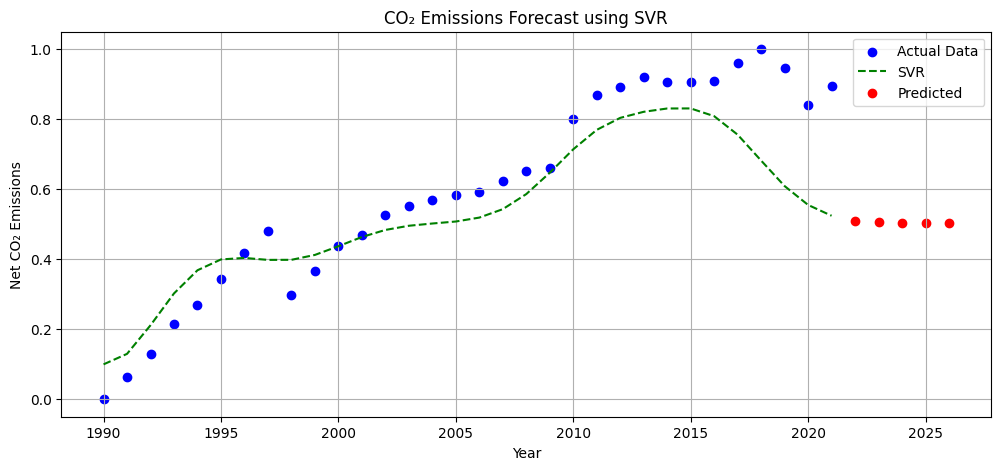

In [58]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 🔹 SVR 모델 학습 (RBF 커널 사용)
    svr_model = SVR(kernel="rbf", C=50, gamma=0.1, epsilon=0.1)
    svr_model.fit(X_train, y_train)

    # 테스트 데이터 예측 및 MSE 계산
    y_pred_test = svr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    mse_scores.append(mse)

    print(f"Fold MSE: {mse:.4f}")

# 🔹 평균 MSE 출력
print(f"✅ 평균 MSE: {np.mean(mse_scores):.4f}")

# 🔹 마지막 모델로 미래 예측
future_predictions_svr = svr_model.predict(future_years)

# 🔹 시각화
plot_predictions(df, svr_model, X, future_years=future_years, future_predictions=future_predictions_svr, model_name="SVR")

# 추가 2) 시계열 분석

In [59]:
# ADF 테스트 (정상성 확인)
adf_result = adfuller(time_series_df["Net"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("데이터가 정상성을 가짐 (p < 0.05)")
else:
    print("데이터가 정상성이 없음 (p >= 0.05)")


ADF Statistic: -1.4879175985206252
P-value: 0.5394796384162662
데이터가 정상성이 없음 (p >= 0.05)


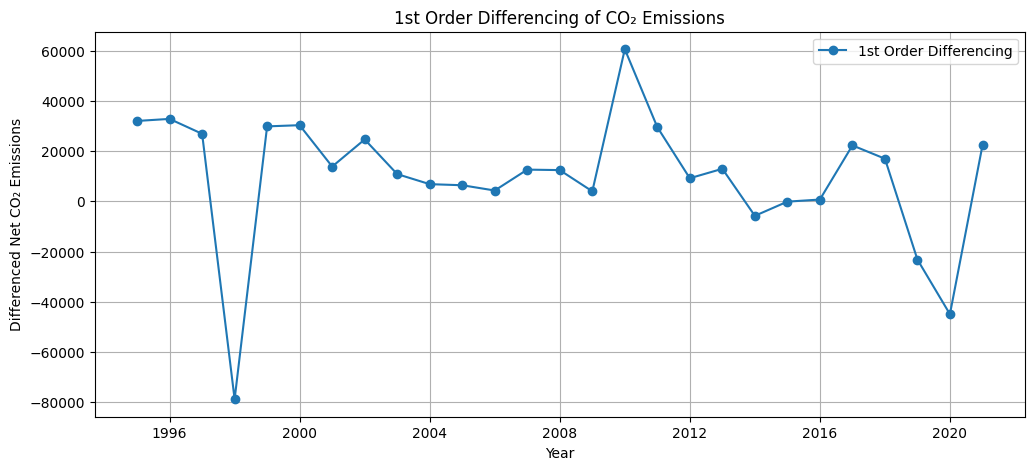

In [60]:
# 1차 차분 적용
time_series_df["Net_diff"] = time_series_df["Net"].diff()
time_series_df.dropna(inplace=True)  # 첫 번째 NaN 제거

# 차분 후 시각화
plt.figure(figsize=(12, 5))
plt.plot(time_series_df["Net_diff"], marker="o", linestyle="-", label="1st Order Differencing")
plt.xlabel("Year")
plt.ylabel("Differenced Net CO₂ Emissions")
plt.title("1st Order Differencing of CO₂ Emissions")
plt.legend()
plt.grid()
plt.show()

In [61]:
# ADF 테스트 (차분 후 정상성 확인)
adf_result = adfuller(time_series_df["Net_diff"])  # NaN 제거
print(f"ADF Statistic (1차 차분): {adf_result[0]}")
print(f"P-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("1차 차분 후 데이터가 정상성을 가짐 (p < 0.05)")
else:
    print("여전히 정상성이 없음. 2차 차분 필요 (p >= 0.05)")

ADF Statistic (1차 차분): -4.96576573705199
P-value: 2.592883861073885e-05
1차 차분 후 데이터가 정상성을 가짐 (p < 0.05)


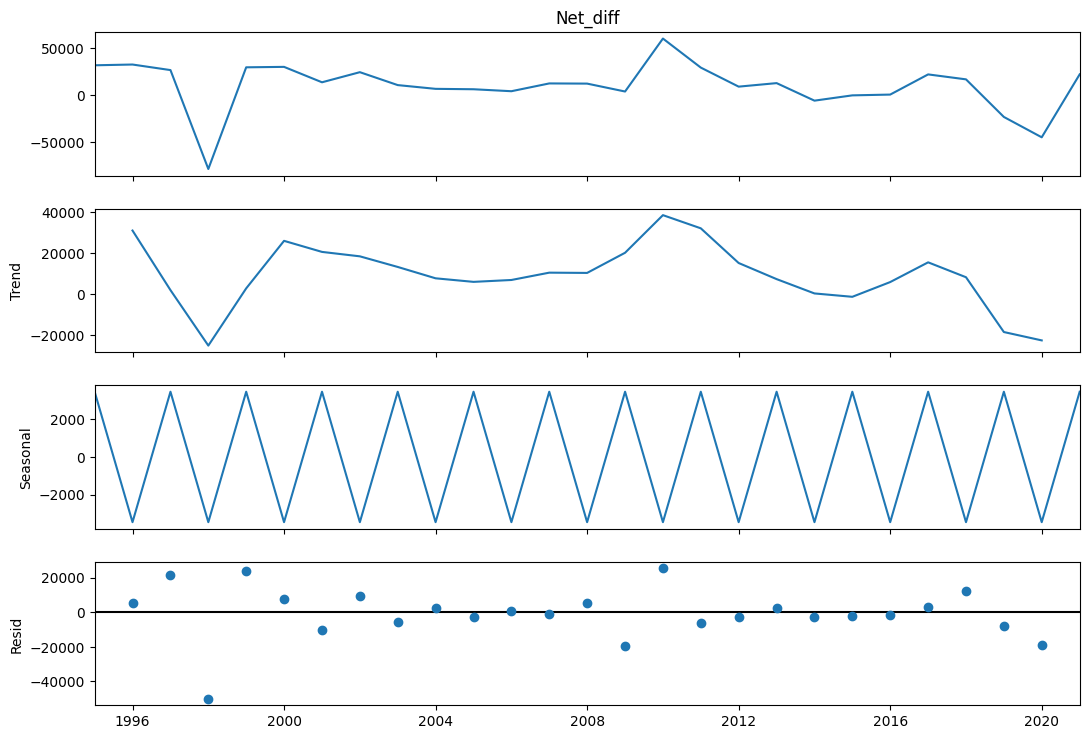

In [62]:
# 시계열 분해 (Trend, Seasonality, Residual)
decomposition = seasonal_decompose(time_series_df["Net_diff"], model="additive", period=2)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()